In [1]:
import os
os.chdir('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df_train = pd.read_csv('data/clean/clean_data_train.csv', index_col=False)
df_test = pd.read_csv('data/clean/clean_data_test.csv', index_col=False)

In [3]:
df_train.head()

,team1,team1score,team2,team2score,match_type,match_stage,player0_id,player0_rating,player0_kd,player1_id,...,player7_kd,player8_id,player8_rating,player8_kd,player9_id,player9_rating,player9_kd,team1_Ranking,team2_Ranking,team_1_won
0,FaZe,0,Spirit,3,BO5,GF,9960.0,1.16,1.14,11816.0,...,1.06,18317,1.07,1.04,7716.0,0.99,0.93,2.0,14.0,0
1,Spirit,2,Falcons,0,BO3,SF,21167.0,1.46,1.47,16920.0,...,1.05,11777,1.05,1.02,922.0,0.83,0.73,14.0,11.0,1
2,MOUZ,0,FaZe,2,BO3,SF,18850.0,1.13,1.23,13666.0,...,1.13,8183,1.11,1.02,429.0,0.94,0.83,5.0,2.0,0
3,ENCE,1,Falcons,2,BO3,QF,16848.0,1.20,1.36,19114.0,...,1.14,11777,1.07,1.05,922.0,0.86,0.76,48.0,11.0,0
4,FaZe,2,G2,0,BO3,QF,9960.0,1.16,1.17,11816.0,...,0.92,9618,0.96,0.89,10096.0,0.89,0.76,2.0,6.0,1


In [4]:
numerical_features = ['team1_Ranking', 'team2_Ranking']
for i in range(10):
    numerical_features.append(f'player{i}_rating')
    numerical_features.append(f'player{i}_kd')


X_train = df_train[numerical_features]
y_train = df_train['team_1_won']


X_test = df_test[numerical_features]
y_test = df_test['team_1_won']

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

accs = []

Cs = 2**np.linspace(-8, 3, 500)
log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear')
cv = GridSearchCV(log_reg_model, param_grid={'penalty': ['l1','l2'],'C': Cs}, cv=10)
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': array([3.90625000e-03, 3.96639504e-03, 4.02746614e-03, 4.08947757e-03,
       4.15244378e-03, 4.21637950e-03, 4.28129965e-03, 4.34721938e-03,
       4.41415408e-03, 4.48211939e-03, 4.55113117e-03, 4.62120553e-03,
       4.69235883e-03, 4.76460769e-03, 4.83796898e-03, 4.91245982e-03,
       4.988...
       5.62941876e+00, 5.71609566e+00, 5.80410713e+00, 5.89347372e+00,
       5.98421631e+00, 6.07635607e+00, 6.16991452e+00, 6.26491350e+00,
       6.36137519e+00, 6.45932211e+00, 6.55877714e+00, 6.65976348e+00,
       6.76230473e+00, 6.86642482e+00, 6.97214806e+00, 7.07949913e+00,
       7.18850310e+00, 7.29918542e+00, 7.41157194e+00, 7.52568888e+00,
       7.64156289e+00, 7.75922103e+00, 7.87869077e+00, 8.00000000e+00]),
                         'penalty': ['l1', 'l2']})

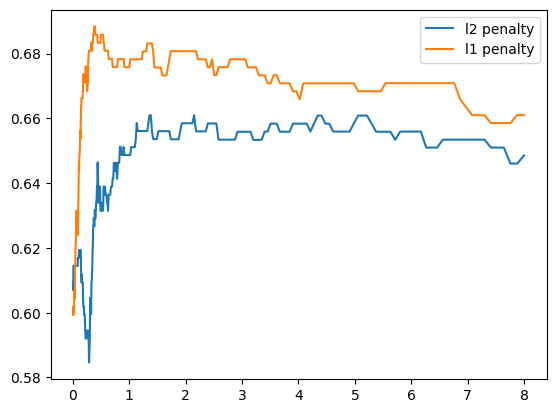

In [6]:
plt.plot(Cs, cv.cv_results_['mean_test_score'][::2], label = 'l2 penalty')
plt.plot(Cs, cv.cv_results_['mean_test_score'][1::2], label = 'l1 penalty')
plt.legend()


In [7]:
from sklearn.metrics import log_loss

log_reg_best = cv.best_estimator_

log_reg_best.fit(X_train, y_train)

y_pred = log_reg_best.predict(X_test)
y_pred_proba = log_reg_best.predict_proba(X_test)

print('Accuracy is', np.mean(y_pred == y_test))

print('Cross entropy score is ', log_loss(y_test, y_pred_proba))


import joblib

# Save the model to a file
joblib.dump(log_reg_best, 'outputs/models/log_reg.pkl')

Accuracy is 0.7941176470588235
Cross entropy score is  0.539657786121049


['outputs/models/log_reg.pkl']

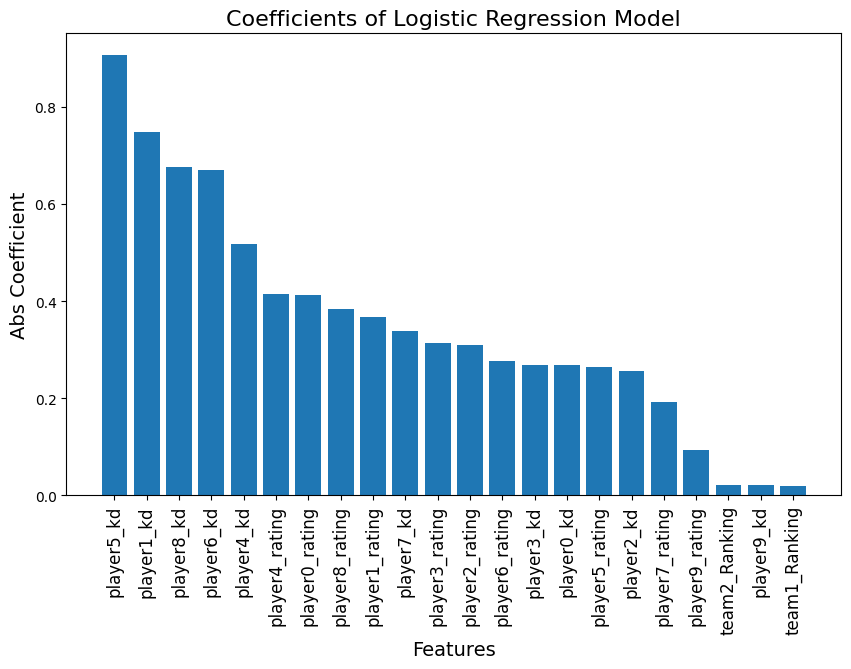

In [8]:

# Get coefficients and feature names
coefficients = abs(log_reg_best.coef_.squeeze())
feature_names = log_reg_best.feature_names_in_

# Sort coefficients and feature names in descending order
sorted_indices = coefficients.argsort()[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Abs Coefficient', fontsize=14)
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.title('Coefficients of Logistic Regression Model', fontsize=16)
plt.show()

Text(0.5, 1.0, 'Permutation Importance of Features')

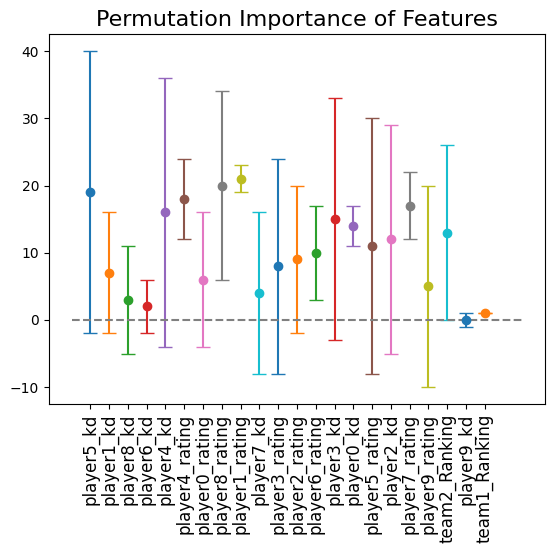

In [9]:
from sklearn.inspection import permutation_importance

r = permutation_importance(log_reg_best, X_test, y_test, n_repeats=30, random_state=42)

for i, mean in enumerate(r.importances_mean.argsort()):
    plt.errorbar(i, mean, yerr=r.importances_std.argsort()[i], fmt='o', capsize=5)

plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=90, fontsize=12)
plt.hlines(0, -1, 23, linestyles='--', colors='grey')

plt.title('Permutation Importance of Features', fontsize=16)


    